### HDS-M05: Deep Learning

**Practical leader and prepared by:** Sharib Ali, PhD

[Setup instructions](https://github.com/sharibox/tutorial/blob/master/HDS-CDT_DL.md)

### Required packages

[1] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[2] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

[3] [Tensorboard](https://pytorch.org/docs/stable/tensorboard.html) is used to visualise your training and validation loss and accuracy development - It is important to observe it!!!

[4] [TorchVision](https://pytorch.org/vision/stable/index.html) you can use available datasets that include one you are required to use in this tutorial (CIFAR10) and also use augmentations (meaning you can increase data variability for improved accuracy and model generalisation)

### Ingrediants of DNN and CNN for image classification

**What will you learn here?**

Here you will build an *l-* layer neural network using pytorch. Each layer can comprise of one or more nodes. Pytorch provides a module **nn** that comprises of building blocks for networks making it easy to code.You will build both Multi-Layer Perceptron (using Fully connected layers) and Convolutional neural networks (using Fully convolutional layers).

<u>For DNN concentrate on</u>:
- Input Units
- Hidden Units
- Output Units
- Activation functions

<u>For CNN concentrate on (ask your tutors if needed)</u>:
- Convolution blocks
- Batch normalisation
- Maxpooling layers
- Activation functions
- Flattenning at the last layer

In [1]:
import torch
import torchvision 
from torch import nn
import numpy as np
# always check your version
print(torch.__version__)

# Load the TensorBoard notebook extension
%load_ext tensorboard

1.10.0


### Data loading and pre-processing
**Steps**

[1] Load data - use torchvision if available in datasets ([torch vision available](https://pytorch.org/vision/stable/datasets.html))

[2] Transform --> Normalise your data - mean and std (e.g., if color then normalise all three channels)
e.g., torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

[3] Transform --> Always convert data to ToTensor (you can do **step 1, 2 and 3** in one line as done in this tutorial)

[4] Make [DataLoaders](https://pytorch.org/docs/stable/data.html): It represents a Python iterable over a dataset

[5] Identify labels 


In [2]:
from torchvision import transforms 
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [3]:
# Preparing transform for step 2 and step 3
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

# Load data and include prepared transform (Remember to apply same transform to both train 
# and test data)
trainset = CIFAR10("data", download=True, train=True, transform=transform)
testset = CIFAR10("data", download=True, train=False, transform=transform)

# Now we need to create dataLoaders that will allow to iterate during training
batch_size = 8 # create batch-based on how much memory you have and your data size
traindataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testdataloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# labels of CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Look into data

In [4]:
# function to unnormalise images and using transpose to change order to [H, W, Channel] 
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([8, 3, 32, 32])
torch.Size([8])


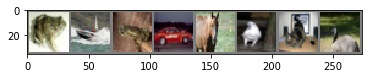

 frog  ship  frog   car horse  bird   cat  bird


In [5]:
import matplotlib.pyplot as plt 
# always check the shape of your training data
dataiter = iter(traindataloader)
images, labels = dataiter.next()

print(images.shape) # batchsize , channel, Height, Width 
print(labels.shape)  # array with label in batchsize 

# show images 
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


### Design a network class for compiling your model 
##### Remember this should have all the above units

nn.Linear module automatically creates a linear transformation with automatically created bias and weight tensors that is used in the forward feed. You can access these using model.hidden.weight or model.hidden.bias 

Recall: $z^{(i)} = w^T x^{(i)} + b \tag{1}$

In [6]:
# Ask tutor if you do not understand what is going on!!!
# Recall your lectur: In DNN we flattent
class ModelDNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(32*32*3, 128) # In DNN we flatten the image (input = channel*height*weight) and 128 is the output layer
        self.fc2 = torch.nn.Linear(128, 256) # hidden layer (first) 128 to another hidden layer (second) 128
        self.fc4 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10) # hidden layer (second) to output layer
        self.sigmoid = torch.nn.Sigmoid() # activation function for second hidden layer
        self.relu = torch.nn.ReLU() # activation function for first hidden layer
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

In [7]:
# call your model here (here input is flattened image: 32*32*3, two hidden layers of feature 128 and then output 10 (no. of labels))
modelDNN = ModelDNN() 
print(modelDNN)

ModelDNN(
  (fc1): Linear(in_features=3072, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)


We have 32*32*3*(128+1) + 128*(128+1) + 128*(10+1) = ? parameters to train


### Training your model

### Prepare an optimizer, set learning rate, and you loss function

In [19]:
# 1] create your optimiser
import torch.optim as optim
learning_rate = 0.001 # Note: this is an important hyperparameter
optimiser = optim.SGD(modelDNN.parameters(), lr = learning_rate,weight_decay=1e-6, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

### Prepare accuracy computation to know how your training is going 

[1] Loss function is important to keep track (mostly you minimise it, i.e. it should go down)

[2] Accuracy in classification is important and you want higher accuracy

[3] You can use TensorBoard to visualize both - on new terminal do below

```shell
ssh -L 8889:127.0.0.1:8889 $user@bdicdtvm01.bmrc.ox.ac.uk 
$ ml Anaconda3
$ source activate base

- run your training below and then do this while waiting:
$ tensorboard --logdir runs/ --port 8889
$ http://127.0.0.1:8889/
```

In [20]:
# define accuracy
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [24]:
%tensorboard --logdir runs/

In [ ]:
# 4] Run your training loop with optimiser trying to minimise your cost/loss, dont forget to backpropagate your loss
device = 'cpu' # set your model to your gpu or cpu (depending on your hardware availability!)
modelDNN.to(device)
modelDNN.train()
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

# define no. of epochs you want to loop 
epochs = 100
log_interval = 10
for epoch in range(epochs):
    train_loss, valid_loss, epoch_accuracy_top1,epoch_accuracy_top5  = [], [], [], []
    
    for batch_idx, (data, label) in enumerate(traindataloader):
        # flatten the image since you are using DNN (32*32*3 will flatten to input size 3072)
        img = (data).view(-1, 32*32*3)
        
        # initialise all your gradients to zero
        optimiser.zero_grad()
        out = modelDNN(img.to(device))
        loss = criterion(out, label.to(device))
        loss.backward()
        optimiser.step()
        
        # append
        train_loss.append(loss.item())
        acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
        epoch_accuracy_top1.append(acc_1[0].item())
        
        if (batch_idx % log_interval) == 0:
            print('Train Epoch is: {}, train loss is: {:.6f}, train accuracy top1% is {}'.format(epoch, np.mean(train_loss),
                                                                                           np.mean(epoch_accuracy_top1)))
            
    # every epoch write the loss and accuracy (these you can see plots on tensorboard)        
    writer.add_scalar('DNN/train_loss', np.mean(train_loss), epoch)
    writer.add_scalar('DNN/train_accuracy', np.mean(epoch_accuracy_top1), epoch)
    
writer.close()

Train Epoch is: 0, train loss is: 1.579558, train accuracy top1% is 50.0
Train Epoch is: 0, train loss is: 1.360789, train accuracy top1% is 50.0
Train Epoch is: 0, train loss is: 1.393380, train accuracy top1% is 51.19047619047619
Train Epoch is: 0, train loss is: 1.335901, train accuracy top1% is 57.25806451612903
Train Epoch is: 0, train loss is: 1.417633, train accuracy top1% is 52.13414634146341
Train Epoch is: 0, train loss is: 1.459984, train accuracy top1% is 49.509803921568626
Train Epoch is: 0, train loss is: 1.429406, train accuracy top1% is 51.4344262295082
Train Epoch is: 0, train loss is: 1.404748, train accuracy top1% is 52.640845070422536
Train Epoch is: 0, train loss is: 1.394516, train accuracy top1% is 53.54938271604938
Train Epoch is: 0, train loss is: 1.382667, train accuracy top1% is 53.70879120879121
Train Epoch is: 0, train loss is: 1.391248, train accuracy top1% is 53.34158415841584
Train Epoch is: 0, train loss is: 1.384256, train accuracy top1% is 53.60360360

Train Epoch is: 0, train loss is: 1.339497, train accuracy top1% is 52.49742533470649
Train Epoch is: 0, train loss is: 1.340709, train accuracy top1% is 52.49745158002039
Train Epoch is: 0, train loss is: 1.339507, train accuracy top1% is 52.598385469223004
Train Epoch is: 0, train loss is: 1.339331, train accuracy top1% is 52.672327672327675
Train Epoch is: 0, train loss is: 1.338862, train accuracy top1% is 52.608803165182984
Train Epoch is: 0, train loss is: 1.338313, train accuracy top1% is 52.644466209598434
Train Epoch is: 0, train loss is: 1.335942, train accuracy top1% is 52.715809893307465
Train Epoch is: 0, train loss is: 1.337026, train accuracy top1% is 52.65369836695485
Train Epoch is: 0, train loss is: 1.337234, train accuracy top1% is 52.723596574690774
Train Epoch is: 0, train loss is: 1.338167, train accuracy top1% is 52.69792648444864
Train Epoch is: 0, train loss is: 1.338371, train accuracy top1% is 52.64939309056956
Train Epoch is: 0, train loss is: 1.336494, trai

Train Epoch is: 0, train loss is: 1.330525, train accuracy top1% is 52.871024734982335
Train Epoch is: 0, train loss is: 1.330690, train accuracy top1% is 52.90055248618785
Train Epoch is: 0, train loss is: 1.330809, train accuracy top1% is 52.911044477761116
Train Epoch is: 0, train loss is: 1.331642, train accuracy top1% is 52.88413724515166
Train Epoch is: 0, train loss is: 1.331376, train accuracy top1% is 52.919346857991094
Train Epoch is: 0, train loss is: 1.332127, train accuracy top1% is 52.90497291974397
Train Epoch is: 0, train loss is: 1.331840, train accuracy top1% is 52.939735423811854
Train Epoch is: 0, train loss is: 1.332202, train accuracy top1% is 52.95587518283764
Train Epoch is: 0, train loss is: 1.332097, train accuracy top1% is 52.95366327025716
Train Epoch is: 0, train loss is: 1.332745, train accuracy top1% is 52.927329792370834
Train Epoch is: 0, train loss is: 1.332662, train accuracy top1% is 52.93128303700144
Train Epoch is: 0, train loss is: 1.332905, train

Train Epoch is: 0, train loss is: 1.327600, train accuracy top1% is 53.020162656726534
Train Epoch is: 0, train loss is: 1.327177, train accuracy top1% is 53.052178318135766
Train Epoch is: 0, train loss is: 1.327191, train accuracy top1% is 53.0713564456412
Train Epoch is: 0, train loss is: 1.326468, train accuracy top1% is 53.09459912780946
Train Epoch is: 0, train loss is: 1.326690, train accuracy top1% is 53.10514877967235
Train Epoch is: 0, train loss is: 1.325790, train accuracy top1% is 53.14895034988337
Train Epoch is: 0, train loss is: 1.325654, train accuracy top1% is 53.155097974094986
Train Epoch is: 0, train loss is: 1.325416, train accuracy top1% is 53.157067196292616
Train Epoch is: 0, train loss is: 1.325623, train accuracy top1% is 53.13840316727153
Train Epoch is: 0, train loss is: 1.325840, train accuracy top1% is 53.1280828674778
Train Epoch is: 0, train loss is: 1.325614, train accuracy top1% is 53.130121271714195
Train Epoch is: 0, train loss is: 1.325290, train a

Train Epoch is: 0, train loss is: 1.325004, train accuracy top1% is 52.96044263546172
Train Epoch is: 0, train loss is: 1.325174, train accuracy top1% is 52.96561786348642
Train Epoch is: 0, train loss is: 1.325864, train accuracy top1% is 52.95178435839028
Train Epoch is: 0, train loss is: 1.325770, train accuracy top1% is 52.95695531431457
Train Epoch is: 0, train loss is: 1.326101, train accuracy top1% is 52.936917652984135
Train Epoch is: 0, train loss is: 1.326258, train accuracy top1% is 52.94209997488068
Train Epoch is: 0, train loss is: 1.326005, train accuracy top1% is 52.94099223252318
Train Epoch is: 0, train loss is: 1.325620, train accuracy top1% is 52.95551112221945
Train Epoch is: 0, train loss is: 1.324940, train accuracy top1% is 52.988656195462475
Train Epoch is: 0, train loss is: 1.325098, train accuracy top1% is 52.96257149962696
Train Epoch is: 0, train loss is: 1.324911, train accuracy top1% is 52.97692880178616
Train Epoch is: 0, train loss is: 1.325065, train ac

Train Epoch is: 0, train loss is: 1.330863, train accuracy top1% is 52.83615588655376
Train Epoch is: 0, train loss is: 1.331075, train accuracy top1% is 52.83801669721034
Train Epoch is: 0, train loss is: 1.330919, train accuracy top1% is 52.8398699451331
Train Epoch is: 0, train loss is: 1.331018, train accuracy top1% is 52.839180693571286
Train Epoch is: 0, train loss is: 1.330927, train accuracy top1% is 52.86379275450314
Train Epoch is: 0, train loss is: 1.330715, train accuracy top1% is 52.87820642294486
Train Epoch is: 0, train loss is: 1.330471, train accuracy top1% is 52.89004233017537
Train Epoch is: 0, train loss is: 1.330294, train accuracy top1% is 52.8842285254476
Train Epoch is: 0, train loss is: 1.330156, train accuracy top1% is 52.885966673358766
Train Epoch is: 0, train loss is: 1.330100, train accuracy top1% is 52.88769785614105
Train Epoch is: 0, train loss is: 1.329623, train accuracy top1% is 52.916916616676666
Train Epoch is: 0, train loss is: 1.329530, train acc

Train Epoch is: 0, train loss is: 1.329288, train accuracy top1% is 53.05126464097776
Train Epoch is: 0, train loss is: 1.329039, train accuracy top1% is 53.06092187764786
Train Epoch is: 0, train loss is: 1.328887, train accuracy top1% is 53.06420233463035
Train Epoch is: 0, train loss is: 1.328673, train accuracy top1% is 53.07169397061307
Train Epoch is: 0, train loss is: 1.328776, train accuracy top1% is 53.07073006238409
Train Epoch is: 0, train loss is: 1.328523, train accuracy top1% is 53.07608146776637
Train Epoch is: 0, train loss is: 1.328592, train accuracy top1% is 53.066711477062675
Train Epoch is: 0, train loss is: 1.328837, train accuracy top1% is 53.05317899681261
Train Epoch is: 0, train loss is: 1.328942, train accuracy top1% is 53.04806565064478
Train Epoch is: 0, train loss is: 1.328732, train accuracy top1% is 53.05759906370172
Train Epoch is: 0, train loss is: 1.328731, train accuracy top1% is 53.05666833583709
Train Epoch is: 0, train loss is: 1.328717, train acc

Train Epoch is: 1, train loss is: 1.285016, train accuracy top1% is 54.62749615975422
Train Epoch is: 1, train loss is: 1.283783, train accuracy top1% is 54.63313161875946
Train Epoch is: 1, train loss is: 1.283167, train accuracy top1% is 54.582712369597616
Train Epoch is: 1, train loss is: 1.282043, train accuracy top1% is 54.62555066079295
Train Epoch is: 1, train loss is: 1.282950, train accuracy top1% is 54.55861070911722
Train Epoch is: 1, train loss is: 1.281755, train accuracy top1% is 54.61840228245364
Train Epoch is: 1, train loss is: 1.282031, train accuracy top1% is 54.67651195499297
Train Epoch is: 1, train loss is: 1.282014, train accuracy top1% is 54.698335644937586
Train Epoch is: 1, train loss is: 1.282567, train accuracy top1% is 54.66826265389877
Train Epoch is: 1, train loss is: 1.279491, train accuracy top1% is 54.77395411605938
Train Epoch is: 1, train loss is: 1.277989, train accuracy top1% is 54.793608521970704
Train Epoch is: 1, train loss is: 1.276079, train a

Train Epoch is: 1, train loss is: 1.279072, train accuracy top1% is 54.508069522036
Train Epoch is: 1, train loss is: 1.279051, train accuracy top1% is 54.472547809993834
Train Epoch is: 1, train loss is: 1.279699, train accuracy top1% is 54.46045370938075
Train Epoch is: 1, train loss is: 1.280448, train accuracy top1% is 54.3951858622791
Train Epoch is: 1, train loss is: 1.278785, train accuracy top1% is 54.48213204118716
Train Epoch is: 1, train loss is: 1.280051, train accuracy top1% is 54.43257074051776
Train Epoch is: 1, train loss is: 1.280968, train accuracy top1% is 54.398563734290846
Train Epoch is: 1, train loss is: 1.282308, train accuracy top1% is 54.372397382510414
Train Epoch is: 1, train loss is: 1.282442, train accuracy top1% is 54.368716735659376
Train Epoch is: 1, train loss is: 1.282791, train accuracy top1% is 54.35773074661964
Train Epoch is: 1, train loss is: 1.283824, train accuracy top1% is 54.30303915838691
Train Epoch is: 1, train loss is: 1.283584, train acc

Train Epoch is: 1, train loss is: 1.280328, train accuracy top1% is 54.25418125243096
Train Epoch is: 1, train loss is: 1.280542, train accuracy top1% is 54.25707090275087
Train Epoch is: 1, train loss is: 1.279581, train accuracy top1% is 54.3081821690467
Train Epoch is: 1, train loss is: 1.278886, train accuracy top1% is 54.339677047289506
Train Epoch is: 1, train loss is: 1.278749, train accuracy top1% is 54.34699348908464
Train Epoch is: 1, train loss is: 1.279769, train accuracy top1% is 54.29702403662724
Train Epoch is: 1, train loss is: 1.279178, train accuracy top1% is 54.304446978335235
Train Epoch is: 1, train loss is: 1.278911, train accuracy top1% is 54.31181370692919
Train Epoch is: 1, train loss is: 1.278982, train accuracy top1% is 54.319124858543944
Train Epoch is: 1, train loss is: 1.278852, train accuracy top1% is 54.31698609545284
Train Epoch is: 1, train loss is: 1.278435, train accuracy top1% is 54.319543242231376
Train Epoch is: 1, train loss is: 1.278331, train a

Train Epoch is: 1, train loss is: 1.275004, train accuracy top1% is 54.35440720923683
Train Epoch is: 1, train loss is: 1.274594, train accuracy top1% is 54.377281662454365
Train Epoch is: 1, train loss is: 1.274596, train accuracy top1% is 54.379025483057966
Train Epoch is: 1, train loss is: 1.273804, train accuracy top1% is 54.42962859536442
Train Epoch is: 1, train loss is: 1.274427, train accuracy top1% is 54.40336953494848
Train Epoch is: 1, train loss is: 1.274852, train accuracy top1% is 54.37725631768953
Train Epoch is: 1, train loss is: 1.275150, train accuracy top1% is 54.35128773193021
Train Epoch is: 1, train loss is: 1.275205, train accuracy top1% is 54.34272300469483
Train Epoch is: 1, train loss is: 1.275378, train accuracy top1% is 54.341090608647754
Train Epoch is: 1, train loss is: 1.275821, train accuracy top1% is 54.329167811040925
Train Epoch is: 1, train loss is: 1.276115, train accuracy top1% is 54.32073404546699
Train Epoch is: 1, train loss is: 1.276033, train 

Train Epoch is: 1, train loss is: 1.273133, train accuracy top1% is 54.5444469075593
Train Epoch is: 1, train loss is: 1.273199, train accuracy top1% is 54.53439504534395
Train Epoch is: 1, train loss is: 1.272911, train accuracy top1% is 54.546457735599205
Train Epoch is: 1, train loss is: 1.273146, train accuracy top1% is 54.533693019158775
Train Epoch is: 1, train loss is: 1.272746, train accuracy top1% is 54.551197539002416
Train Epoch is: 1, train loss is: 1.272863, train accuracy top1% is 54.54121903091427
Train Epoch is: 1, train loss is: 1.273360, train accuracy top1% is 54.53948807700722
Train Epoch is: 1, train loss is: 1.273541, train accuracy top1% is 54.53776468020083
Train Epoch is: 1, train loss is: 1.273152, train accuracy top1% is 54.54149422783707
Train Epoch is: 1, train loss is: 1.272853, train accuracy top1% is 54.55879156705064
Train Epoch is: 1, train loss is: 1.273108, train accuracy top1% is 54.54619388418998
Train Epoch is: 1, train loss is: 1.272587, train ac

Train Epoch is: 1, train loss is: 1.275176, train accuracy top1% is 54.49193986596631
Train Epoch is: 1, train loss is: 1.275465, train accuracy top1% is 54.47703851021515
Train Epoch is: 1, train loss is: 1.275729, train accuracy top1% is 54.47121458220538
Train Epoch is: 1, train loss is: 1.275615, train accuracy top1% is 54.46766348405693
Train Epoch is: 1, train loss is: 1.275966, train accuracy top1% is 54.450638374393094
Train Epoch is: 1, train loss is: 1.275994, train accuracy top1% is 54.46508705797882
Train Epoch is: 1, train loss is: 1.275723, train accuracy top1% is 54.479483963447414
Train Epoch is: 1, train loss is: 1.275764, train accuracy top1% is 54.46476480057235
Train Epoch is: 1, train loss is: 1.276044, train accuracy top1% is 54.46125691840743
Train Epoch is: 1, train loss is: 1.275856, train accuracy top1% is 54.468900374264834
Train Epoch is: 1, train loss is: 1.275882, train accuracy top1% is 54.474292830457216
Train Epoch is: 1, train loss is: 1.275802, train 

Train Epoch is: 2, train loss is: 1.201906, train accuracy top1% is 57.61494252873563
Train Epoch is: 2, train loss is: 1.200850, train accuracy top1% is 57.47232472324723
Train Epoch is: 2, train loss is: 1.199280, train accuracy top1% is 57.829181494661924
Train Epoch is: 2, train loss is: 1.200014, train accuracy top1% is 57.81786941580756
Train Epoch is: 2, train loss is: 1.207505, train accuracy top1% is 57.51661129568107
Train Epoch is: 2, train loss is: 1.204196, train accuracy top1% is 57.47588424437299
Train Epoch is: 2, train loss is: 1.203160, train accuracy top1% is 57.71028037383178
Train Epoch is: 2, train loss is: 1.202700, train accuracy top1% is 57.70392749244713
Train Epoch is: 2, train loss is: 1.201822, train accuracy top1% is 57.84457478005865
Train Epoch is: 2, train loss is: 1.206759, train accuracy top1% is 57.47863247863248
Train Epoch is: 2, train loss is: 1.204536, train accuracy top1% is 57.75623268698061
Train Epoch is: 2, train loss is: 1.211067, train acc

Train Epoch is: 2, train loss is: 1.218328, train accuracy top1% is 56.754596322941644
Train Epoch is: 2, train loss is: 1.217309, train accuracy top1% is 56.76050753370341
Train Epoch is: 2, train loss is: 1.215452, train accuracy top1% is 56.835169158143195
Train Epoch is: 2, train loss is: 1.216282, train accuracy top1% is 56.78181108508977
Train Epoch is: 2, train loss is: 1.217268, train accuracy top1% is 56.661502711076686
Train Epoch is: 2, train loss is: 1.217451, train accuracy top1% is 56.648731744811684
Train Epoch is: 2, train loss is: 1.217782, train accuracy top1% is 56.65522501906941
Train Epoch is: 2, train loss is: 1.216963, train accuracy top1% is 56.68054504163513
Train Epoch is: 2, train loss is: 1.216852, train accuracy top1% is 56.696093163035314
Train Epoch is: 2, train loss is: 1.216902, train accuracy top1% is 56.711409395973156
Train Epoch is: 2, train loss is: 1.216436, train accuracy top1% is 56.7079940784604
Train Epoch is: 2, train loss is: 1.216241, train

Train Epoch is: 2, train loss is: 1.220520, train accuracy top1% is 56.29146395400265
Train Epoch is: 2, train loss is: 1.220223, train accuracy top1% is 56.29678555702334
Train Epoch is: 2, train loss is: 1.220646, train accuracy top1% is 56.25822007891276
Train Epoch is: 2, train loss is: 1.220302, train accuracy top1% is 56.27455259711916
Train Epoch is: 2, train loss is: 1.221036, train accuracy top1% is 56.26358105171664
Train Epoch is: 2, train loss is: 1.221091, train accuracy top1% is 56.25811337083513
Train Epoch is: 2, train loss is: 1.221092, train accuracy top1% is 56.25807841447652
Train Epoch is: 2, train loss is: 1.220630, train accuracy top1% is 56.26340626340626
Train Epoch is: 2, train loss is: 1.220556, train accuracy top1% is 56.268688594617686
Train Epoch is: 2, train loss is: 1.220487, train accuracy top1% is 56.26860910250957
Train Epoch is: 2, train loss is: 1.220215, train accuracy top1% is 56.289707750952985
Train Epoch is: 2, train loss is: 1.220186, train ac

Train Epoch is: 2, train loss is: 1.230648, train accuracy top1% is 56.21301775147929
Train Epoch is: 2, train loss is: 1.230734, train accuracy top1% is 56.19372865569699
Train Epoch is: 2, train loss is: 1.230799, train accuracy top1% is 56.19003404518725
Train Epoch is: 2, train loss is: 1.230558, train accuracy top1% is 56.20564640543042
Train Epoch is: 2, train loss is: 1.230591, train accuracy top1% is 56.19424792371578
Train Epoch is: 2, train loss is: 1.230346, train accuracy top1% is 56.186752529898804
Train Epoch is: 2, train loss is: 1.230451, train accuracy top1% is 56.17548150412718
Train Epoch is: 2, train loss is: 1.230196, train accuracy top1% is 56.187138067662296
Train Epoch is: 2, train loss is: 1.231189, train accuracy top1% is 56.16074141598298
Train Epoch is: 2, train loss is: 1.231225, train accuracy top1% is 56.15722508330809
Train Epoch is: 2, train loss is: 1.231597, train accuracy top1% is 56.13862881304742
Train Epoch is: 2, train loss is: 1.231685, train ac

Train Epoch is: 2, train loss is: 1.231664, train accuracy top1% is 56.122937096388426
Train Epoch is: 2, train loss is: 1.231928, train accuracy top1% is 56.1172751133381
Train Epoch is: 2, train loss is: 1.232044, train accuracy top1% is 56.11461556772197
Train Epoch is: 2, train loss is: 1.232384, train accuracy top1% is 56.09118974115412
Train Epoch is: 2, train loss is: 1.232442, train accuracy top1% is 56.082681828950484
Train Epoch is: 2, train loss is: 1.232112, train accuracy top1% is 56.10375797683763
Train Epoch is: 2, train loss is: 1.232017, train accuracy top1% is 56.11294506012733
Train Epoch is: 2, train loss is: 1.232091, train accuracy top1% is 56.1191484356622
Train Epoch is: 2, train loss is: 1.232561, train accuracy top1% is 56.098920441210986
Train Epoch is: 2, train loss is: 1.232384, train accuracy top1% is 56.102200889721374
Train Epoch is: 2, train loss is: 1.232384, train accuracy top1% is 56.09378649848166
Train Epoch is: 2, train loss is: 1.232280, train ac

Train Epoch is: 2, train loss is: 1.231625, train accuracy top1% is 56.116097278517664
Train Epoch is: 2, train loss is: 1.231557, train accuracy top1% is 56.116355230206125
Train Epoch is: 2, train loss is: 1.231546, train accuracy top1% is 56.109402038069604
Train Epoch is: 2, train loss is: 1.231694, train accuracy top1% is 56.107273076184995
Train Epoch is: 2, train loss is: 1.231563, train accuracy top1% is 56.11472897912277
Train Epoch is: 2, train loss is: 1.231650, train accuracy top1% is 56.10781877270121
Train Epoch is: 2, train loss is: 1.231680, train accuracy top1% is 56.10331997710361
Train Epoch is: 2, train loss is: 1.231644, train accuracy top1% is 56.11550180917921
Train Epoch is: 2, train loss is: 1.231970, train accuracy top1% is 56.11100551226003
Train Epoch is: 2, train loss is: 1.232092, train accuracy top1% is 56.08992601024474
Train Epoch is: 2, train loss is: 1.231984, train accuracy top1% is 56.09496307517516
Train Epoch is: 2, train loss is: 1.231934, train 

Train Epoch is: 2, train loss is: 1.233675, train accuracy top1% is 56.13592311419803
Train Epoch is: 2, train loss is: 1.233661, train accuracy top1% is 56.1401386873085
Train Epoch is: 2, train loss is: 1.233809, train accuracy top1% is 56.1423281275157
Train Epoch is: 2, train loss is: 1.234051, train accuracy top1% is 56.14049188233403
Train Epoch is: 2, train loss is: 1.233999, train accuracy top1% is 56.144679826673084
Train Epoch is: 2, train loss is: 1.233895, train accuracy top1% is 56.150857234417565
Train Epoch is: 3, train loss is: 1.101154, train accuracy top1% is 62.5
Train Epoch is: 3, train loss is: 1.221919, train accuracy top1% is 52.27272727272727
Train Epoch is: 3, train loss is: 1.248562, train accuracy top1% is 53.57142857142857
Train Epoch is: 3, train loss is: 1.327077, train accuracy top1% is 51.61290322580645
Train Epoch is: 3, train loss is: 1.291124, train accuracy top1% is 52.74390243902439
Train Epoch is: 3, train loss is: 1.284381, train accuracy top1% is

Train Epoch is: 3, train loss is: 1.184198, train accuracy top1% is 58.29633740288568
Train Epoch is: 3, train loss is: 1.180688, train accuracy top1% is 58.479692645444565
Train Epoch is: 3, train loss is: 1.181046, train accuracy top1% is 58.469055374592834
Train Epoch is: 3, train loss is: 1.178942, train accuracy top1% is 58.51235230934479
Train Epoch is: 3, train loss is: 1.179396, train accuracy top1% is 58.48831030818278
Train Epoch is: 3, train loss is: 1.179829, train accuracy top1% is 58.412197686645634
Train Epoch is: 3, train loss is: 1.180644, train accuracy top1% is 58.363683662851194
Train Epoch is: 3, train loss is: 1.180305, train accuracy top1% is 58.38053553038105
Train Epoch is: 3, train loss is: 1.182693, train accuracy top1% is 58.32059123343527
Train Epoch is: 3, train loss is: 1.183297, train accuracy top1% is 58.31231079717457
Train Epoch is: 3, train loss is: 1.183056, train accuracy top1% is 58.31668331668332
Train Epoch is: 3, train loss is: 1.182442, train 

Train Epoch is: 3, train loss is: 1.185025, train accuracy top1% is 58.309095716552086
Train Epoch is: 3, train loss is: 1.185224, train accuracy top1% is 58.2982640715413
Train Epoch is: 3, train loss is: 1.185431, train accuracy top1% is 58.24829931972789
Train Epoch is: 3, train loss is: 1.184543, train accuracy top1% is 58.257418011452366
Train Epoch is: 3, train loss is: 1.184068, train accuracy top1% is 58.30528223718281
Train Epoch is: 3, train loss is: 1.183753, train accuracy top1% is 58.3397733127254
Train Epoch is: 3, train loss is: 1.182779, train accuracy top1% is 58.373910814966685
Train Epoch is: 3, train loss is: 1.183655, train accuracy top1% is 58.38220295767466
Train Epoch is: 3, train loss is: 1.183063, train accuracy top1% is 58.371385083713854
Train Epoch is: 3, train loss is: 1.182671, train accuracy top1% is 58.40484603735487
Train Epoch is: 3, train loss is: 1.182520, train accuracy top1% is 58.425414364640886
Train Epoch is: 3, train loss is: 1.183245, train a

Train Epoch is: 3, train loss is: 1.186141, train accuracy top1% is 58.261020479000344
Train Epoch is: 3, train loss is: 1.186534, train accuracy top1% is 58.22379799377378
Train Epoch is: 3, train loss is: 1.186251, train accuracy top1% is 58.234229576008275
Train Epoch is: 3, train loss is: 1.186159, train accuracy top1% is 58.253177602198555
Train Epoch is: 3, train loss is: 1.186379, train accuracy top1% is 58.25915782266347
Train Epoch is: 3, train loss is: 1.186755, train accuracy top1% is 58.24377345615831
Train Epoch is: 3, train loss is: 1.186772, train accuracy top1% is 58.23699421965318
Train Epoch is: 3, train loss is: 1.186996, train accuracy top1% is 58.2175533717384
Train Epoch is: 3, train loss is: 1.186538, train accuracy top1% is 58.24045930428909
Train Epoch is: 3, train loss is: 1.187117, train accuracy top1% is 58.22534500168293
Train Epoch is: 3, train loss is: 1.186731, train accuracy top1% is 58.23549144582355
Train Epoch is: 3, train loss is: 1.187043, train ac

Train Epoch is: 3, train loss is: 1.195090, train accuracy top1% is 57.78443113772455
Train Epoch is: 3, train loss is: 1.195163, train accuracy top1% is 57.77720072708387
Train Epoch is: 3, train loss is: 1.195416, train accuracy top1% is 57.766770266770266
Train Epoch is: 3, train loss is: 1.195474, train accuracy top1% is 57.75639369671919
Train Epoch is: 3, train loss is: 1.195560, train accuracy top1% is 57.76539551661943
Train Epoch is: 3, train loss is: 1.196217, train accuracy top1% is 57.758288357748654
Train Epoch is: 3, train loss is: 1.195936, train accuracy top1% is 57.77364778261984
Train Epoch is: 3, train loss is: 1.196393, train accuracy top1% is 57.7825364356942
Train Epoch is: 3, train loss is: 1.196198, train accuracy top1% is 57.79456771231828
Train Epoch is: 3, train loss is: 1.196374, train accuracy top1% is 57.781098957008396
Train Epoch is: 3, train loss is: 1.196863, train accuracy top1% is 57.770870337477795
Train Epoch is: 3, train loss is: 1.196822, train a

Train Epoch is: 3, train loss is: 1.197172, train accuracy top1% is 57.738467960759756
Train Epoch is: 3, train loss is: 1.197357, train accuracy top1% is 57.72234951051864
Train Epoch is: 3, train loss is: 1.197013, train accuracy top1% is 57.72968197879859
Train Epoch is: 3, train loss is: 1.197121, train accuracy top1% is 57.73957685127567
Train Epoch is: 3, train loss is: 1.197116, train accuracy top1% is 57.73131856758435
Train Epoch is: 3, train loss is: 1.196649, train accuracy top1% is 57.73858706878744
Train Epoch is: 3, train loss is: 1.196251, train accuracy top1% is 57.750979179550605
Train Epoch is: 3, train loss is: 1.196337, train accuracy top1% is 57.742748405677844
Train Epoch is: 3, train loss is: 1.196059, train accuracy top1% is 57.75251488400739
Train Epoch is: 3, train loss is: 1.196119, train accuracy top1% is 57.754558492112274
Train Epoch is: 3, train loss is: 1.196456, train accuracy top1% is 57.74637088529953
Train Epoch is: 3, train loss is: 1.196665, train 

Train Epoch is: 3, train loss is: 1.194566, train accuracy top1% is 57.836596776988394
Train Epoch is: 3, train loss is: 1.194536, train accuracy top1% is 57.82736550769763
Train Epoch is: 3, train loss is: 1.194806, train accuracy top1% is 57.81816611984113
Train Epoch is: 3, train loss is: 1.194600, train accuracy top1% is 57.83485605930012
Train Epoch is: 3, train loss is: 1.194491, train accuracy top1% is 57.83858199965582
Train Epoch is: 3, train loss is: 1.194385, train accuracy top1% is 57.84014774093799
Train Epoch is: 3, train loss is: 1.194302, train accuracy top1% is 57.83527696793003
Train Epoch is: 3, train loss is: 1.194619, train accuracy top1% is 57.834702961821606
Train Epoch is: 3, train loss is: 1.195010, train accuracy top1% is 57.82131259613741
Train Epoch is: 3, train loss is: 1.195659, train accuracy top1% is 57.805835181709604
Train Epoch is: 3, train loss is: 1.195403, train accuracy top1% is 57.81595980241867
Train Epoch is: 3, train loss is: 1.195561, train a

In [ ]:
# Test predictions in a DNN
# calculate test accuracy (while applying test/val you will need to use torch.no_grad())
total = 0
with torch.no_grad():
    for data in testdataloader:
        image, labels = data
        img = (image).view(-1, 32*32*3)
        output = modelDNN(img.to(device))
        _, preds_tensor = torch.max(output, 1)
        acc_1_test = topk_accuracy(output, labels.to(device),topk=(1,) )
        total +=np.mean(acc_1_test[0].detach().cpu().numpy())

In [ ]:
print('test accuracy is {}% on {} samples of CIFAR10 test dataset'.format(total/len(testdataloader), len(testdataloader)))

In [ ]:
# Alternatively you can compute for each class seperately as well 
#(taken from: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testdataloader:
        images, labels = data
        img = (images).view(-1, 32*32*3) # Note you should remove it for CNN because you do not flatten 
        outputs = modelDNN(img.to(device))
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.to(device) == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

### Let's train a CNN model on the same data now

- Here, you will be building a **CNN network** with convolution filters of fixed kernel sizes
    
- You will need to understand the shape of image and how to use kernels and max-pooling layers

- You will build a 2 layer convolutional neural network 

- You will use **Conv2d, BatchNorm, ReLU (activation), MaxPooling, and linear layer** (*fully connected*)
    
#### Explaination to Conv2d: 
- 3: no. of input channel ---> (unlike DNN you put the number of input channels)
- 32: is the feature output (can be of 16/32/64/128 etc...)
- kernel size: will change the size of the image (stride and padding will also influence that. Read details here: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- stride of 1 with padding 1 and kernel_size 3 will not change image size (your image size is 32 x 32)

#### Notes of Maxpooling
- Downscales the image size by 2 (32 x 32 will change to 16 x 16)    

In [ ]:
import torch.nn.functional as F 
# activation functions like relu and softmax are here that you can use directly in forward function
# i.e., 

class ModelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ## define the layers: you can write this all as nn.Sequence to call in one line
        
        # first 2D convolution layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.act = nn.ReLU(inplace=True) 
        # Think what is the size now?
        
        # Downscaling by 2 (16)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # second 2D convolution layer, think what is the size now? 
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.act2 = nn.ReLU(inplace=True)
        self.pooling2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # think about how this came? Ask your tutors if needed!!!
        self.fc = nn.Linear(16*8*8, 10)

    
    def forward(self, x):
        
        x = self.pooling(self.act(self.bn1(self.conv1(x))))
        # Alternatively (if you do not define above in above we can directly apply F.relu)
        # x = self.pooling(F.relu(self.bn1(self.conv1(x))))
        x = self.pooling2(self.act2(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

In [ ]:
import torch.optim as optim
modelCNN = ModelCNN()
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 # set your learning rate (crucial)
# set your optimiser (alternatively you can select other optimisers like Adam, RMSProp etc.)
optimiser = optim.SGD(modelCNN.parameters(), lr = learning_rate,weight_decay=1e-6, momentum = 0.9)

In [ ]:
# training starts here (you can make this as a function)
modelCNN.to(device)
# define no. of epochs you want to loop (TODO: increase your number of iterations)
epochs = 10
log_interval = 10
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

for epoch in range(epochs):
    train_loss, valid_loss, epoch_accuracy_top1,epoch_accuracy_top5  = [], [], [], []
    for batch_idx, (data, label) in enumerate(traindataloader):
        # initialise all your gradients to zero
        optimiser.zero_grad()
        out = modelCNN(data.to(device))
        loss = criterion(out, label.to(device))
        loss.backward()
        optimiser.step()
        
        # append
        train_loss.append(loss.item())
        acc_1 = topk_accuracy(out, label.to(device),topk=(1,))
        epoch_accuracy_top1.append(acc_1[0].item())
        
        if (batch_idx % log_interval) == 0:
            print('Train Epoch is: {}, train loss is: {:.6f}, train accuracy top1% is {}'.format(epoch, np.mean(train_loss),
                                                                                               np.mean(epoch_accuracy_top1)))
            
    # every epoch write the loss and accuracy (these you can see plots on tensorboard)        
    writer.add_scalar('CNN/train_loss', np.mean(train_loss), epoch)
    writer.add_scalar('CNN/train_accuracy', np.mean(epoch_accuracy_top1), epoch)
    
writer.close()

In [ ]:
### Test predictions in a CNN (TODO: please fill this by yourself, you can take reference from above)
# Compute total test accuracy
total = 0
with torch.no_grad():
    for data in testdataloader:
        image, labels = data
        output = modelCNN(image.to(device))
        _, preds_tensor = torch.max(output, 1)
        acc_1_test = topk_accuracy(output, labels.to(device),topk=(1,) )
        total +=np.mean(acc_1_test[0].detach().cpu().numpy())
print('test accuracy is {}% on {} samples of CIFAR10 test dataset'.format(total/len(testdataloader), len(testdataloader)))
# TODO 2: Compute per class test accuracy
# Your code here:




### Improving your network peerformance

- Add more layers
- Train for larger batch size and epochs (longer)
- Try changing kernel size in Conv2d (Remember size will change - recall your lecture/ask tutor)
- Tune your hyperparameters and decay rate


#### Exercise: Build a CNN network with more feature layers and perform training on CIFAR10 
You can also refer to: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Please use a separate ipython notebook to do this (**Assignment to be submmitted**)
- You can use parts of the code provided in this notebook
- Due on **Wednesday 3rd November, 2021 (11:59 PM)** (*You will be graded for this exercise*)

<h3>Thanks for completing this lesson!</h3>

Any comments or feedbacks and your solution to exercise, please send to [Sharib Ali](sharib.ali@eng.ox.ac.uk)